# Python model of the radar link equation for Metsähovi SLR

This notebook is an interactive Python version of the radar link equation as given in Degnan (1993), and earlier implemented in Excel by Diego.

The equation gives the number of photoelectrons expected to be received for a single laser pulse,

\begin{align}
n_e = \eta_q \left( E_T \frac{\lambda}{hc} \right)  \eta_t G_t \sigma \left( \frac{1}{4 \pi R^2}\right)^2A_r \eta_r T_a^2 T_c^2,
\end{align}

where $\eta_q$ is the detector quantum efficiency, $E_T$ is the energy of the laser pulse, $\lambda$ is the laser wavelength, $h$ the Planck constant, $c$ the speed of light, $\eta_t$ the efficiency of the transmit optics, $G_t$ the transmitter gain, $\sigma$ the target's optical cross section, $R$ the slant range to the target, $A_r$ the telescope aperture area, $\eta_r$ the efficiency of the receive optics, $T_a$ the one-way atmospheric transmission and $T_c$ the one-way transmission of cirrus clouds.


## Utility functions and constants

We first import and define some utility functions and natural constants that are used in the calculation. First we import some mathematical functions and matplotlib for plots (and give the `%matplotlib inline` command to the Notebook to draw the plots inline instead of separate windows).

In [1]:
from math import sqrt, cos, pi, exp, factorial
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

Next we define constants: the product of the Planck constant and the speed of light, and the radius of the Earth (in meters).

In [2]:
CONST_HC = 6.626176e-34 * 2.99792458e8
R_Earth = 6378000.0

Next is a function that takes all the values in a Python dictionary and multiplies them together. This is used in calculating the optical efficiencies from individual optical components.

In [3]:
def multiply_values(D):
    result = 1
    for value in D.values():
        result *= value
    return result

## Properties of the laser and telescope

Here we define the laser pulse energy $E_T$ (in Joules) and the wavelength $\lambda$ (in meters).

In [4]:
pulse_energy = 4e-4 # Joules
wavelength = 532e-9 # meters
eta_q = 0.2
aperture = 0.188 # square meters
station_altitude = 64.5 # meters

## Optical efficiencies

The transmit/receive optical efficiencies $\eta_t$ and $\eta_r$ are products of the efficiencies of all of the individual optical elements. These individual efficiencies are given in a Python dictionary, whose values are then multiplied together to get the final value.

### Transmit efficiency

In [5]:
transmit_optics = {
    "TM1" : 1.00000,
    "TM2" : 0.99995,
    "TM3" : 0.99995,
    "BEx1" : 0.99900,
    "TM4" : 0.99995,
    "TM5" : 0.99000,
    "CW1" : 0.99900,
    "CM1" : 0.99000,
    "CM2" : 0.99000,
    "CM3" : 0.99000,
    "CM4" : 0.99000,
    "CM5" : 0.99000,
    "BEx2" : 0.99900,
    "CW2" : 0.99900
}

These values are multiplied to compute $\eta_t$.

In [6]:
eta_t = multiply_values(transmit_optics)

print("eta_t = {:.5f}".format(eta_t))

eta_t = 0.93758


### Receive efficiency

The bandpass filter value is $0.900$ for night time observations and $0.600$ for the daytime filter. This is defined conditionally on the variable `night`.

In [7]:
night = True

Then we compute the value of $\eta_r$ from the values of the optics.

In [8]:
receive_optics = {
    "telW" : 0.999,
    "primM" : 0.960,
    "secM" : 0.960,
    "detBoxW" : 0.999,
    "coll" : 0.999,
    "DichM1" : 0.990,
    "bandpass" : 0.900 if night else 0.600,
    "NDfilter" : 0.999
}

In [9]:
eta_r = multiply_values(receive_optics)

print("eta_r = {:.5f}".format(eta_r))

eta_r = 0.81787


## Slant range calculation

The following function computes the slant range to the target, given the station height (from a spherical Earth) and the target height, as well as the zenith angle to the target.

The slant range is defined by Degnan (1993) as 

\begin{align}
R = -(R_E + H_t) \cos \theta_z + \sqrt{(R_E + h_t)^2 \cos^2 \theta_z + 2 R_E (h_s - h_t)+ h_s^2 - h_t^2},
\end{align}

where $R_E$ is the Earth radius (6378 km), $h_t$ is the station height above the Earth surface, $h_s$ is the satellite's altitude, and $\theta_z$ is the zenith angle of the satellite as seen from the station.

The Python function takes the zenith angle in degrees.

In [10]:
def slant_range(h_station, h_target, theta_z):
    r_station = R_Earth + h_station
    cosz = cos(theta_z * pi/180)
    t = sqrt(r_station**2 * cosz**2 + 2*R_Earth*(h_target-h_station) + h_target**2 - h_station**2)
    return -r_station * cosz + t

## Transmitter gain

The formula given by Degnan (1993) for $G_t$ of a Gaussian beam is

\begin{align}
G_t = \frac{8}{\theta_t^2}\exp\left[ -2 \left( \frac{\theta}{\theta_t} \right) \right],
\end{align}

where $\theta_t$ is the far-field divergence half-angle between the beam centre and the $1/e^2$ intensity point, and $\theta$ is the beam pointing error ($\theta$ is labeled "seeing" in Diego's Excel).

The Python function takes in the angles in arcseconds. The multiplication by the constant $0.0000048481$ converts arcseconds to radians.

In [11]:
def gain(theta_t, theta):
    return 8/(0.0000048481*theta_t)**2 * exp(-2*(theta/theta_t)**2)

In Diego's Excel, the value of 2.5 arcseconds was used for both of these angles.

In [12]:
Gt = gain(2.5, 2.5)

print("Gt = {:.4e}".format(Gt))

Gt = 7.3702e+09


## Atmospheric effects

### Atmospheric transmittance

Atmospheric transmittance $T_A$ is given by Degnan (1993) as

\begin{align}
T_A(\lambda, V, h_t) = \exp \left[ -\sigma_\text{atm}(\lambda, V, 0) h_\text{scale} \sec \theta_z \exp \left( -\frac{h_t}{h_\text{scale}}\right) \right],
\end{align}

where $h_t$ is the target altitude, $\sigma_\text{atm}(\lambda, V, 0)$ is the attenuation coefficient at wavelength $\lambda$ at sea level visibility $V$ at sea level altitude, and the scale height $h_\text{scale}$ = 1.2 km. The attenuation coefficient $\sigma$ is highly wavelength-dependent. Degnan doesn't give a value for $\sigma$, but refers to the RCA Electro-Optics Handbook for plots of $\sigma$ as a function of $\lambda$ and $V$.

Diego used hard-coded values for $T_A$. His values were computed from a simplified model where each unit of air mass $\sec \theta_z$ reduces the transmittance by a constant value.

\begin{align}
T_A &= T_0 - \Delta T \sec \theta_z,
\end{align}

The values he used can be found by examining the table in his Excel sheet. The change by air mass $\Delta T$ is $0.15$ for green light and $0.07$ for infrared light. The value of $T_0$ depends on the atmospheric conditions like so:

| Condition      | V       | $T_0$, green | $T_0$, IR |
|----------------|---------|---------------------------
| Very clear     | 50 km   |     0.95     |   1.04    |
| Standard clear | 23.5 km |     0.84     |   0.93    |
| Clear          | 15 km   |     0.72     |   0.82    |
| Light haze     | 8 km    |     0.59     |   0.54    |

Here's a Python implementation that takes the $T_0$ and $\Delta T$ parameters, as well as $\theta_z$ in degrees.

In [13]:
def atmospheric_transmittance(T0, delta, theta_z):
    theta_z *= pi/180
    return T0 - delta / cos(theta_z)

### Cirrus transmittance

Cirrus cloud transmittance is given by Degnan as

\begin{align}
T_c = -\exp(-0.14 (t \sec \theta_z)^2),
\end{align}

where $t$ is a "cirrus cloud thickness", that has been observed to be in the 0 to 4 range when clouds are present (see Figure 9a in Degnan's paper). The angle $\theta_z$ should be given to the function in degrees.

In [14]:
def cirrus_transmittance(t, theta_z):
    theta_z *= pi/180
    return exp(-0.14 * (t / cos(theta_z))**2)

## The radar link equation

Finally, here is the Python implementation of the radar link equation, 

\begin{align}
n_e= \eta_q \left( E_T \frac{\lambda}{hc} \right)  \eta_t G_t \sigma \left( \frac{1}{4 \pi R^2}\right)^2A_r \eta_r T_a^2 T_c^2.
\end{align}

The variables are given to the function in the same order as they appear in the equation.

In [15]:
def n_electrons(eta_q, pulse_energy, wavelength, eta_t, transmit_gain, cross_section,
                R, aperture, eta_r, T_atmos, T_cirrus):
    N = eta_q * pulse_energy * wavelength / CONST_HC
    N *= eta_t * transmit_gain * cross_section / (4*pi*R**2)**2
    N *= aperture * eta_r
    N *= T_atmos**2 * T_cirrus**2
    return N

## Probability of detection

After we know the expected number of photoelectrons per pulse, we can move onto the probability of detection. From Poisson statistics, we can compute that the probability of detecting at least $n_{th}$ photoelectrons per pulse, given the mean number of photoelectrons received $n$, is

\begin{align}
p(n, n_{th}) = 1 - e^{-n} \sum_{m=0}^{n_{th}-1} \frac{n^m}{m!}.
\end{align}

When the threshold $n_{th}=2$, this becomes $ p(n,2) = 1 - e^{-n} \left(1 + n\right)$, which is what Diego's Excel calculation uses.

In [16]:
def pulse_probability(n, threshold):
    S = 0
    for m in range(threshold):
        S += n**m / factorial(m)
    return 1 - exp(-n) * S

## Detections per second

The number of detections per second depends on all of the above, as well as the laser fire rate $f$ (pulses per second). The probability of exactly $m$ detections per second, when the probability of dection per pulse is $p$, comes from the binomial distribution,

\begin{align}
p(f, m) = \binom{f}{m} p^m (1-p)^{f-m}
\end{align}

In [17]:
def binomial(f, m, p):
    return comb(f, m, exact=False) * p**m * (1-p)**(f-m) 

The probability that *at least* $k$ detections per second is then

\begin{align}
p_\text{detect}(f, k) = 1 - \sum_{m=0}^{k-1} p(f, m)
\end{align}

In [18]:
def detection_probability(f, k, p):
    return 1 - sum(binomial(f, m, p) for m in range(k))

# Computation

## Computing probabilities by height and zenith angle

We compute the probability that there are at least 6 detections per second for a 2 kHz laser. 

In [19]:
fire_rate = 2000 # pulses per second
electrons_per_detection = 2
detections_per_second = 6

We use 100 different altitudes from 100 km to 450 km and eight zenith angles ranging from 70° to 0°.

In [20]:
altitudes = np.linspace(100e3, 450e3, 100)
zenith_angles = [70, 60, 50, 40, 30, 20, 10, 0]

We use a 3 square meter optical cross section, and relatively good sky and cirrus conditions.

In [21]:
cross_section = 3 # square meters
T_cirrus = 0.8
T_atmos = 0.7

We loop over the zenith angles and satellite altitudes. For each zenith angle, we first compute the slant range, then the expected number of photoelectrons `ne`. Then the detection probabilities at each altitude are put in a list, which is plotted in the figure.

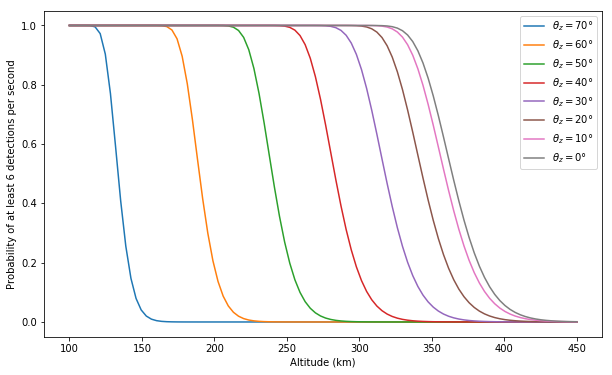

In [22]:
for theta_z in zenith_angles:
    probabilities = []
    for satellite_altitude in altitudes:
        R = slant_range(station_altitude, satellite_altitude, theta_z)
        ne = n_electrons(eta_q, pulse_energy, wavelength, eta_t, Gt, cross_section,
                R, aperture, eta_r, T_atmos, T_cirrus)
        p_single = pulse_probability(ne, electrons_per_detection)
        p = detection_probability(fire_rate, detections_per_second, p_single)
        probabilities.append(p)
    
    plt.plot(altitudes / 1000, probabilities, label="$\\theta_z = {}°$".format(theta_z))
    
lgd = plt.legend(loc="upper right")
plt.xlabel("Altitude (km)")
plt.ylabel("Probability of at least {} detections per second".format(detections_per_second))
        
